<a href="https://colab.research.google.com/github/HarrisonWBlack/Machine-Learning-CAP-5610/blob/master/Assignment%203/HW3_part1234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem 1**

Do feature extraction with data augmentation.

In [0]:
# Harrison Black
# HA435377
# CAP 5610
# UCF Spring 2019

from keras import backend as k
k.clear_session()

In [589]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 02:13:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  31.3MB/s    in 2.1s    

2019-04-18 02:13:06 (31.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_dogs_dir = os.path.join(train_dir, 'dogs')
train_cats_dir = os.path.join(train_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))


In [593]:
from keras import layers
from keras import models
from keras import optimizers


layer = conv_base.output
layer = layers.Flatten()(layer)
layer = layers.Dense(256, activation='relu')(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Dense(1,activation='sigmoid')(layer)
model = models.Model(inputs=[conv_base.input], outputs=[layer])

for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= 22

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [594]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
    
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

path="./my_model.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=10)
callbacks = [cp, stop_early]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 19s 194ms/step - loss: 0.7174 - acc: 0.5450 - val_loss: 0.5348 - val_acc: 0.7490

Epoch 00001: val_acc improved from -inf to 0.74900, saving model to ./my_model.h5
Epoch 2/30
100/100 [==============================] - 18s 179ms/step - loss: 0.5835 - acc: 0.6945 - val_loss: 0.4506 - val_acc: 0.8070

Epoch 00002: val_acc improved from 0.74900 to 0.80700, saving model to ./my_model.h5
Epoch 3/30
100/100 [==============================] - 18s 178ms/step - loss: 0.5307 - acc: 0.7325 - val_loss: 0.4091 - val_acc: 0.8210

Epoch 00003: val_acc improved from 0.80700 to 0.82100, saving model to ./my_model.h5
Epoch 4/30
100/100 [==============================] - 20s 195ms/step - loss: 0.4947 - acc: 0.7650 - val_loss: 0.3822 - val_acc: 0.8320

Epoch 00004: val_acc improved from 0.82100 to 0.83200, saving model to ./my_model.h5
Epoch 5/30
100/100 [===============

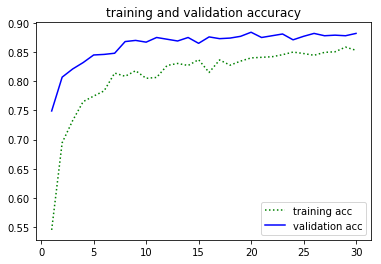

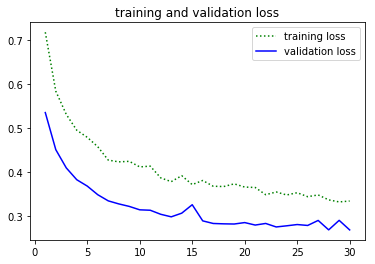

Validation loss: 0.2657185013592243
Validation accuracy: 0.8839999997615814


In [595]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='training acc', linestyle=":")
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='training loss', linestyle=":")
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

### **Problem 2**

Do fine-tuning with data augmentation.

In [596]:
model.load_weights("my_model.h5")
for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= 20
    
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [597]:
path="./my_model_tuned.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=20)
callbacks = [cp, stop_early]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3546 - acc: 0.8510 - val_loss: 0.2589 - val_acc: 0.8930

Epoch 00001: val_acc improved from -inf to 0.89300, saving model to ./my_model_tuned.h5
Epoch 2/30
100/100 [==============================] - 18s 179ms/step - loss: 0.3409 - acc: 0.8565 - val_loss: 0.2551 - val_acc: 0.8830

Epoch 00002: val_acc did not improve from 0.89300
Epoch 3/30
100/100 [==============================] - 18s 178ms/step - loss: 0.3303 - acc: 0.8525 - val_loss: 0.3256 - val_acc: 0.8590

Epoch 00003: val_acc did not improve from 0.89300
Epoch 4/30
100/100 [==============================] - 19s 187ms/step - loss: 0.3180 - acc: 0.8555 - val_loss: 0.2645 - val_acc: 0.8840

Epoch 00004: val_acc did not improve from 0.89300
Epoch 5/30
100/100 [==============================] - 18s 181ms/step - loss: 0.3087 - acc: 0.8575 - val_loss: 0.2589 - val_acc: 0.8880

Epoch 00005: val_acc did not improve from 0.89300
Epoch 6/30
100/100 [============

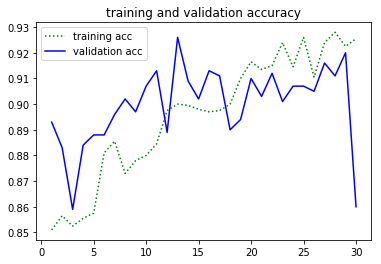

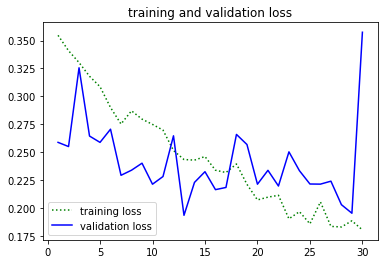

Validation loss: 0.35535342890769245
Validation accuracy: 0.8639999997615814


In [598]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='training acc', linestyle=":")
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='training loss', linestyle=":")
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

### **Problem 3**

Visualize heatmaps of class activation for the the model obtained in Problem 2.

In [0]:
from keras.applications.vgg19 import VGG19 
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

In [600]:
!wget https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?raw=true \
  -O dog1.jpg
  
!wget https://static-cdn.jtvnw.net/jtv_user_pictures/dogdog-profile_image-5550ade194780dfc-300x300.jpeg?raw=true \
  -O dog2.jpeg
  
!wget https://hips.hearstapps.com/ghk.h-cdn.co/assets/18/01/1515005599-miniature-pinscher.jpg?raw=true \
  -O dog3.jpg
  
!wget https://www.catster.com/wp-content/uploads/2018/07/Savannah-cat-long-body-shot.jpg?raw=true \
  -O cat1.jpg  
  
!wget https://ichef.bbci.co.uk/images/ic/720x405/p0517py6.jpg?raw=true \
  -O cat2.jpg  

!wget https://peopledotcom.files.wordpress.com/2018/04/zappa-the-cat-4.jpg?raw=true \
  -O cat3.jpg

--2019-04-18 02:31:42--  https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?raw=true
Resolving cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)... 185.172.149.128, 2a0b:4d07:202::1
Connecting to cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)|185.172.149.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41880 (41K) [image/jpeg]
Saving to: ‘dog1.jpg’

dog1.jpg            100%[===================>]  40.90K  --.-KB/s    in 0s      

2019-04-18 02:31:42 (330 MB/s) - ‘dog1.jpg’ saved [41880/41880]

--2019-04-18 02:31:43--  https://static-cdn.jtvnw.net/jtv_user_pictures/dogdog-profile_image-5550ade194780dfc-300x300.jpeg?raw=true
Resolving static-cdn.jtvnw.net (static-cdn.jtvnw.net)... 151.101.38.214
Connecting to static-cdn.jtvnw.net (static-cdn.jtvnw.net)|151.101.38.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30264 (30K) [image/jpeg]
Saving to: ‘dog2.jpeg’

dog2.jpeg        

In [0]:
img_path1 = 'dog1.jpg'
img_path2 = 'dog2.jpeg'
img_path3 = 'dog3.jpg'
img_path4 = 'cat1.jpg'
img_path5 = 'cat2.jpg'
img_path6 = 'cat3.jpg'

classes = ["Doggo", "Kitty Cat"]

In [0]:
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from skimage.transform import resize

In [0]:
def show_superimposed_image(img_path, heatmap):
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  superimposed_img = cv2.resize(superimposed_img, (300, 300))
  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(150, 150))
  plt.imshow(img)
  plt.grid(None)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  heatmap = np.mean(conv_layer_output_value, axis=-1) 
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

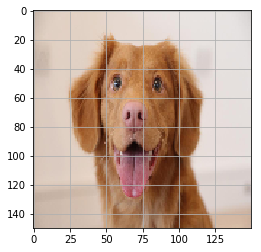

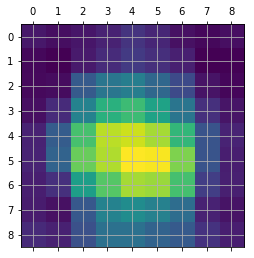

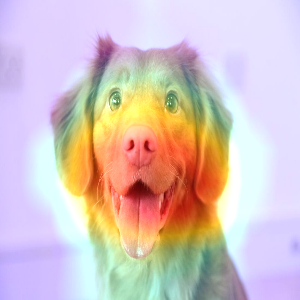

In [606]:
process_image(img_path1)

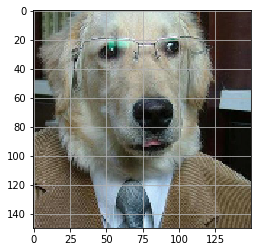

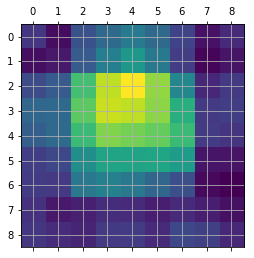

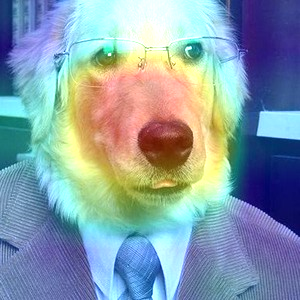

In [607]:
process_image(img_path2)

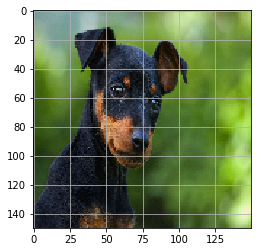

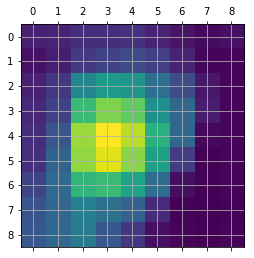

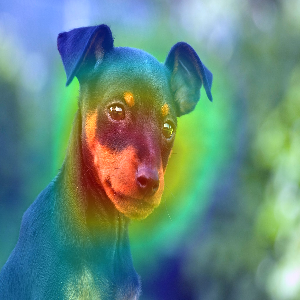

In [608]:
process_image(img_path3)

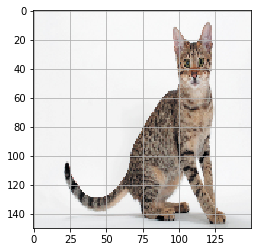

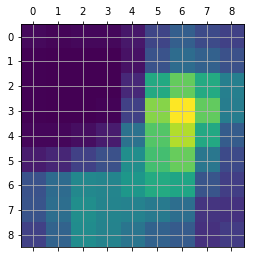

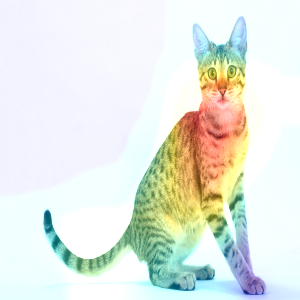

In [609]:
process_image(img_path4)

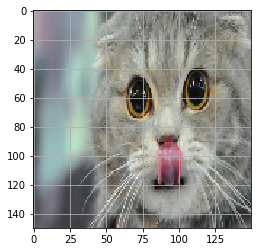

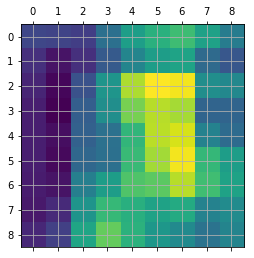

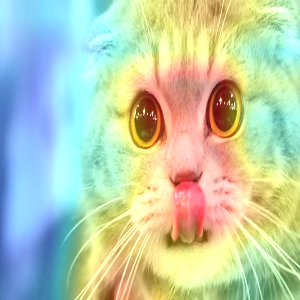

In [610]:
process_image(img_path5)

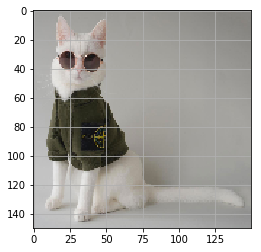

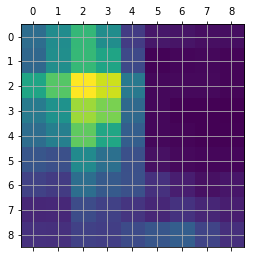

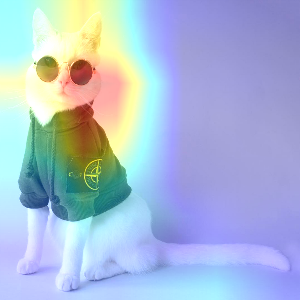

In [611]:
process_image(img_path6)

### **Problem 4**

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.

In [0]:
import time
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

In [613]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = next(validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=350,
    class_mode='binary'))

imgs, labels = validation_generator
layer = model.get_layer('dense_2')
layer_output = layer.output
activation_model = models.Model(input=model.input, outputs=[layer_output])
activations = activation_model.predict(imgs)
activations.shape

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  # This is added back by InteractiveShellApp.init_path()


(350, 1)

In [0]:
def data_scatter(vecs, labels):
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    for idx in range(num_classes):
        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, classes[idx], fontsize=16)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

t-SNE done! Time elapsed: 1.7801399230957031 seconds


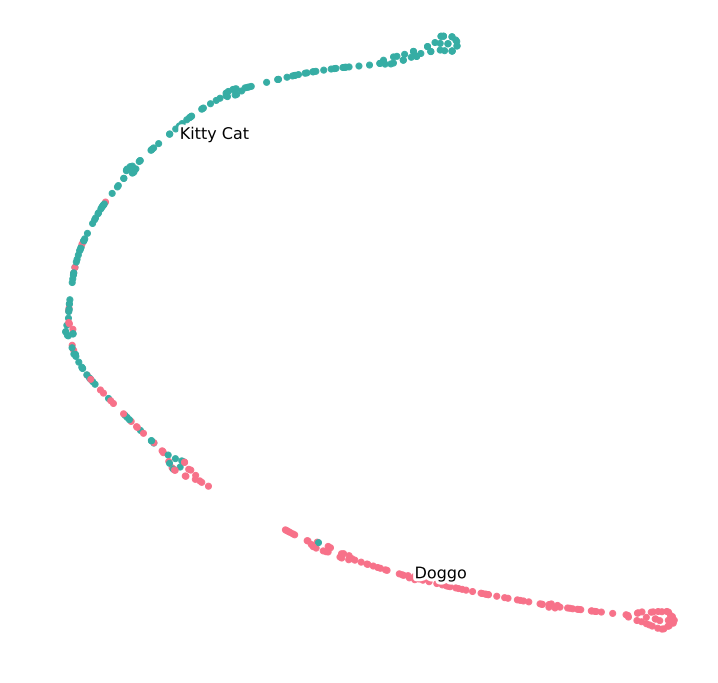

In [615]:
time_start = time.time()
doggies_tsne = TSNE(random_state=42).fit_transform(activations)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))
data_scatter(doggies_tsne, labels)